# Dự Báo Thời Tiết Vệ Tinh

Vui lòng sử dụng Google Colab để xác minh giải pháp của bạn trước.
Chúng tôi rất xin lỗi về vấn đề nộp giải pháp. Lý do là do Trung Quốc đại lục không thể truy cập trực tiếp vào huggingface.co, có quá nhiều rào cản mạng giữa Máy chủ Kiểm tra và huggingface.co cũng như hf-mirror.com. Chúng tôi hiện đang xác định vấn đề, điều này có thể mất một thời gian.

Liên kết Google Colab cho nhiệm vụ này là https://colab.research.google.com/drive/14tI_EARXubr6NNl7T_Ikhz0A5-Jhy2hZ?usp=sharing. Các thí sinh có thể tải xuống bộ dữ liệu và gỡ lỗi ngoại tuyến. Tuy nhiên, rất khuyến khích các thí sinh sử dụng Bohrium để làm quen với nền tảng cuộc thi. Giai đoạn thi tại chỗ sẽ không cung cấp liên kết Google Colab.

Bạn là một học sinh trung học thực tập tại phòng thí nghiệm khí hậu khu vực, làm việc cùng một nhóm nhỏ các nhà khoa học tập trung vào việc cải thiện dự báo lượng mưa chỉ sử dụng hình ảnh vệ tinh. Theo truyền thống, mưa được đo bằng radar và cảm biến mặt đất — nhưng những hệ thống này tốn kém và thường không có sẵn ở các vùng xa xôi.

<img src="../IOAI-2025-main\IOAI-2025-main\At-Home-Round\Weather\figs\Weather Fig 1.png" width="400">

Khi phân tích hình ảnh vệ tinh GOES-16, bạn nảy ra một ý tưởng:

> "Điều gì sẽ xảy ra nếu chúng ta có thể huấn luyện một mô hình để phát hiện mưa trực tiếp từ hình ảnh vệ tinh — ngay cả khi không có dữ liệu mặt đất? Và nếu chúng ta sử dụng thêm ngữ cảnh như góc mặt trời, thời gian trong ngày và vị trí để cải thiện độ chính xác?"

Các nhà khoa học rất hứng thú. Bạn được quyền truy cập vào một kho lưu trữ lớn dữ liệu vệ tinh và mặt nạ lượng mưa — và một thách thức: chứng minh rằng nó có thể hoạt động. Nếu thành công, phương pháp của bạn có thể giúp các nông dân nhỏ ở các vùng thiếu dịch vụ lập kế hoạch tưới tiêu hiệu quả hơn và giảm thiệt hại mùa màng.

Nhiệm vụ của bạn: xây dựng một mô hình nhìn vào bầu trời — và nói cho chúng ta biết liệu trời có mưa hay không.

## Nhiệm Vụ

Nhiệm vụ của bạn là phát triển một mô hình AI nhận hình ảnh vệ tinh từ vệ tinh GOES-16 làm đầu vào; và dự đoán — cho từng pixel — liệu có mưa xảy ra tại vị trí tương ứng trên Trái đất hay không. Đây là một nhiệm vụ **phân đoạn ngữ nghĩa**: mô hình của bạn nên xuất ra một mặt nạ nhị phân chỉ ra "mưa" hoặc "không mưa" tại mỗi pixel.

Bạn có thể huấn luyện và đánh giá mô hình của mình bằng cách sử dụng dữ liệu lượng mưa thực tế được cung cấp bởi bộ dữ liệu MRMS (Multi-Radar Multi-Sensor).

Một mô hình phân đoạn baseline dựa trên U-Net đã được huấn luyện trước được cung cấp để giúp bạn bắt đầu.

**Bạn ĐƯỢC PHÉP:**

- Tinh chỉnh hoặc sửa đổi U-Net baseline
- Sử dụng metadata (ví dụ: vĩ độ, kinh độ, thời gian, độ cao mặt trời)
- Sửa đổi logic suy luận (ví dụ: ngưỡng, xử lý hậu kỳ)

**Bạn KHÔNG ĐƯỢC PHÉP:**

- Sử dụng bất kỳ bộ dữ liệu bên ngoài nào
- Sử dụng các mô hình đã được huấn luyện trước bên ngoài khác ngoài baseline được cung cấp
- Tìm kiếm các bài báo về dự báo thời tiết trên internet. Mặc dù đây là nhiệm vụ tại nhà, nó được thiết kế để chuẩn bị cho bạn cho cuộc thi tại chỗ.

## Dữ Liệu

Bộ dữ liệu bao gồm các quan sát vệ tinh từ năm 2024 và bao gồm những điều sau:

- **Hình ảnh Đa kênh GOES-16 ABI**  
  16 kênh quang phổ (C01–C16), bao phủ một loạt các bước sóng:

  - C01–C03: ánh sáng nhìn thấy
  - C04–C06: cận hồng ngoại
  - C07–C16: hồng ngoại  
    Hình ảnh được cắt thành các miếng vá có kích thước 128×128 hoặc 256×256 pixel.

- **Mặt nạ lượng mưa** từ hệ thống MRMS, cung cấp nhãn nhị phân (mưa/không mưa) cho mỗi pixel.

- **Metadata**, bao gồm:
  - Vĩ độ và kinh độ của góc trên bên trái của miếng vá
  - Thời gian bắt đầu và kết thúc theo UTC (việc chụp tất cả 16 kênh mất ~10 phút)
  - Một tiện ích Python để tính **góc độ cao mặt trời** dựa trên thời gian và vị trí

### Phân Chia Huấn Luyện-Xác Thực

- **Tập huấn luyện** thiên về các cảnh có mưa: chỉ các miếng vá có ít nhất 3% pixel chứa mưa mới được bao gồm.
- **Tập xác thực** được thiết kế để phản ánh điều kiện thế giới thực: nhiều miếng vá chứa ít hoặc không có mưa. Ngoài ra, một số mẫu có thể bao gồm các vấn đề truyền tải — ví dụ, một số kênh quang phổ có thể bị thiếu hoặc bị hỏng một cách có chủ ý.

## Đánh Giá

Mô hình của bạn sẽ được đánh giá trên hai chỉ số:

- **Điểm Dice Trung Bình**:  
  Đo lường mức độ khớp của mặt nạ dự đoán với thực tế, từng pixel một. Công thức là 2 × |giao điểm| / (|dự đoán| + |thực tế|).

- **Độ Chính Xác Mưa Cấp Hình Ảnh**:  
  Đo lường liệu mô hình của bạn có phân loại chính xác xem có mưa nào xuất hiện trong hình ảnh hay không. Điều này là do đôi khi bạn không cần phân đoạn từng giọt mưa — chỉ cần biết liệu trời có mưa hay không là đủ. Ngay cả một dự đoán chính xác cũng có thể giúp bảo vệ toàn bộ cánh đồng cây trồng.

- **Điểm Cuối Cùng**:
  Điểm Cuối Cùng = (Điểm Dice Trung Bình + Độ Chính Xác Mưa Cấp Hình Ảnh) / 2.

## Bản Quyền

Tất cả dữ liệu được sử dụng trong thách thức này đều có sẵn công khai:

- Dữ liệu vệ tinh **GOES-16 ABI** từ NOAA và NESDIS
- Dữ liệu lượng mưa **MRMS** từ Phòng thí nghiệm Bão Nghiêm Trọng Quốc gia (NSSL) của NOAA

## Nộp Bài

Notebook của bạn cần tạo ra một file `submission.zip` chứa dự đoán của bạn trên tập kiểm tra công khai `pred_a.npz` và dự đoán của bạn trên tập kiểm tra riêng tư `pred_b.npz`. Mỗi file `.npz` nên chứa `Y_pred_128` (hình dạng $51 \times 128 \times 128$) và `Y_pred_256` (hình dạng $183 \times 256 \times 256$), dự đoán boolean của bạn cho mỗi tập kiểm tra.

```python
# đầu tiên tạo pred_a.npz

model.eval()
model.to(DEVICE)

Y_pred_128 = []
with torch.no_grad():
    for i in tqdm(range(len(X_test[128]))):
        x = X_test[128][i]
        metadata = df[(df['size'] == 128) & (df['split'] == 'test') & (df['ind'] == i)] # ví dụ sử dụng metadata
        logits = model(x.unsqueeze(0).to(torch.float32).to(DEVICE))
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float().squeeze(0)
        Y_pred_128.append(preds.cpu().detach().numpy())
Y_pred_128 = np.concatenate(Y_pred_128, axis=0)

print(Y_pred_128.shape)

Y_pred_256 = []
with torch.no_grad():
    for i in tqdm(range(len(X_test[256]))):
        x = X_test[256][i]
        metadata = df[(df['size'] == 256) & (df['split'] == 'test') & (df['ind'] == i)]
        logits = model(x.unsqueeze(0).to(torch.float32).to(DEVICE))
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float().squeeze(0)
        Y_pred_256.append(preds.cpu().detach().numpy())
Y_pred_256 = np.concatenate(Y_pred_256, axis=0)

print(Y_pred_256.shape)

# Bạn phải đặt tên mảng dự đoán của mình là `Y_pred_128` và `Y_pred_256`, và đặt tên file là `pred_a.npz` cho bảng xếp hạng công khai
np.savez('pred_a.npz', Y_pred_128=Y_pred_128, Y_pred_256=Y_pred_256)
```

```
100%|██████████| 51/51 [00:00<00:00, 53.08it/s]
(51, 128, 128)
100%|██████████| 183/183 [00:08<00:00, 21.31it/s]
(183, 256, 256)
```

```python
# Notebook của bạn sẽ có quyền truy cập vào bộ dữ liệu kiểm tra thông qua biến môi trường DATA_PATH sau khi nộp bài.
TEST_PATH = os.environ.get('DATA_PATH', "test")

test = np.load(Path(TEST_PATH) / "X_test.npz") # Đọc dữ liệu kiểm tra từ X_test.npz dưới đường dẫn được cung cấp

X_test = {
    128: torch.from_numpy(test['X_test_128']),
    256: torch.from_numpy(test['X_test_256']),
} # chỉ X_test sẽ được cung cấp

df_test = pd.read_csv(Path(TEST_PATH) / "metadata_test.csv") # Đọc metadata từ metadata_test.csv dưới đường dẫn được cung cấp
```

```python
Y_pred_128 = []
with torch.no_grad():
    for i in tqdm(range(len(X_test[128]))):
        x = X_test[128][i]
        metadata = df_test[(df_test['size'] == 128) & (df_test['ind'] == i)] # ví dụ sử dụng metadata
        logits = model(x.unsqueeze(0).to(torch.float32).to(DEVICE))
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float().squeeze(0)
        Y_pred_128.append(preds.cpu().detach().numpy())
Y_pred_128 = np.concatenate(Y_pred_128, axis=0)

print(Y_pred_128.shape)

Y_pred_256 = []
with torch.no_grad():
    for i in tqdm(range(len(X_test[256]))):
        x = X_test[256][i]
        metadata = df_test[(df_test['size'] == 256) & (df_test['ind'] == i)]
        logits = model(x.unsqueeze(0).to(torch.float32).to(DEVICE))
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float().squeeze(0)
        Y_pred_256.append(preds.cpu().detach().numpy())
Y_pred_256 = np.concatenate(Y_pred_256, axis=0)

print(Y_pred_256.shape)

# Bạn phải đặt tên mảng dự đoán của mình là `Y_pred_128` và `Y_pred_256`, và đặt tên file là `pred_b.npz` cho bảng xếp hạng riêng tư
np.savez('pred_b.npz', Y_pred_128=Y_pred_128, Y_pred_256=Y_pred_256)
```

```
100%|██████████| 51/51 [00:00<00:00, 58.14it/s]
(51, 128, 128)
100%|██████████| 183/183 [00:08<00:00, 22.31it/s]
(183, 256, 256)
```

```python
# nén `pred_a.npz` và `pred_b.npz` thành `submission.zip`
with zipfile.ZipFile('submission.zip', 'w') as zipf:
    zipf.write('pred_a.npz')
    zipf.write('pred_b.npz')
```


In [1]:
# @title
from huggingface_hub import hf_hub_download
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import zipfile
from tqdm import tqdm
from datetime import datetime, timedelta
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

DATASET = hf_hub_download(
    repo_id="Silicon23/ioai2025-athome-satellite-images",
    filename="data/dataset.npz",
    repo_type="dataset",
    cache_dir='E:\Luyen-AIO\data_weather'
)
METADATA = hf_hub_download(
    repo_id="Silicon23/ioai2025-athome-satellite-images",
    filename="data/metadata.csv",
    repo_type="dataset",
    cache_dir='E:\Luyen-AIO\data_weather'
)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BASELINE_MODEL = hf_hub_download(
    repo_id="Silicon23/ioai2025-athome-satellite-baseline",
    filename="model_weights.pth",
    cache_dir='E:\Luyen-AIO\data_weather'
)

In [2]:
import numpy as np
# data = np.load(r"E:\Luyen-AIO\data_weather\datasets--Silicon23--ioai2025-athome-satellite-images\snapshots\27255089c8c860b43ee2041ce6fca35f6f7be178\data\dataset.npz")
data = np.load(DATASET)

In [3]:
data['X_train_128'][0].shape

(16, 128, 128)

In [4]:
data['Y_train_128'][0].shape

(128, 128)

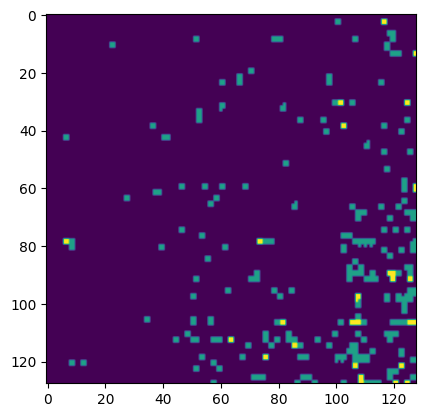

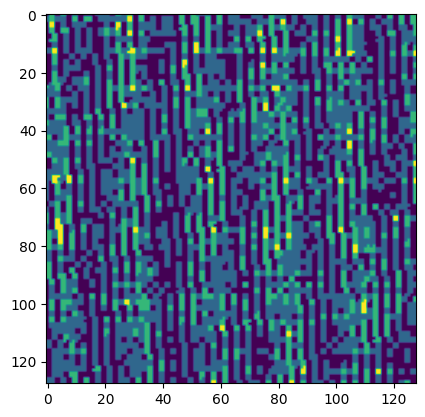

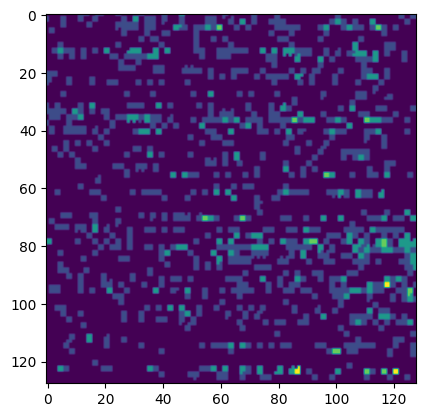

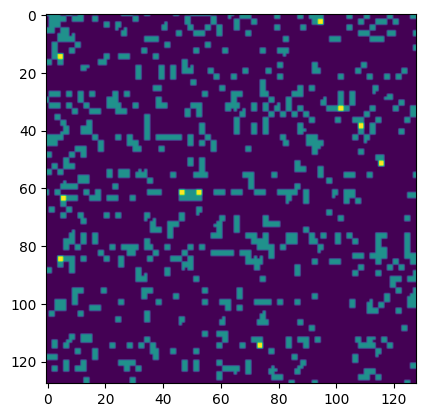

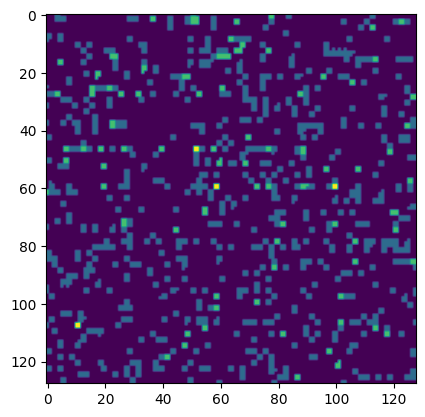

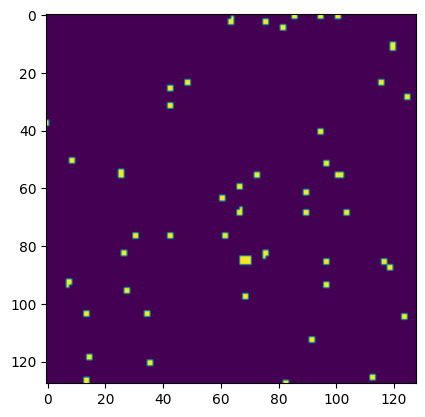

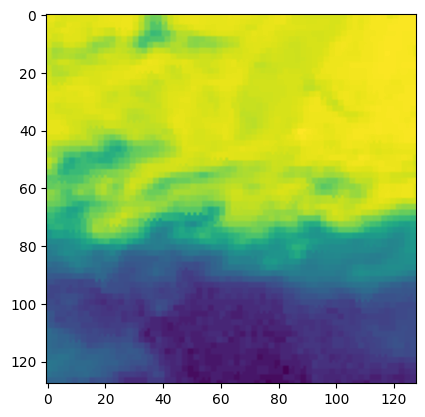

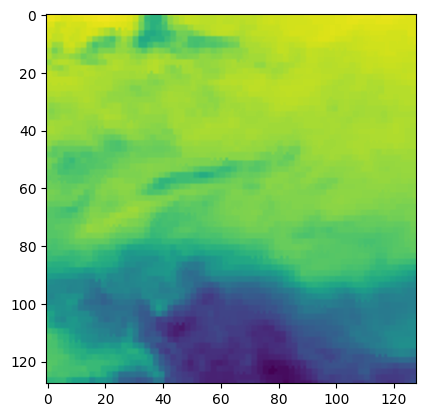

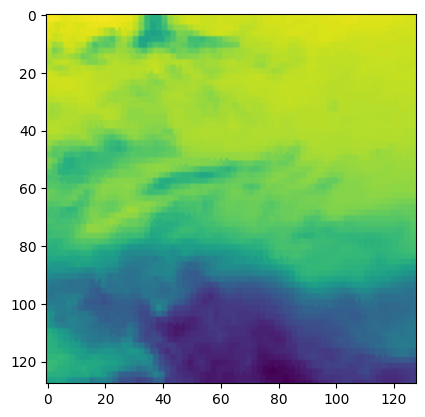

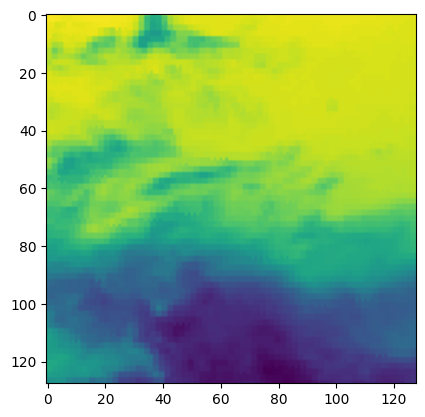

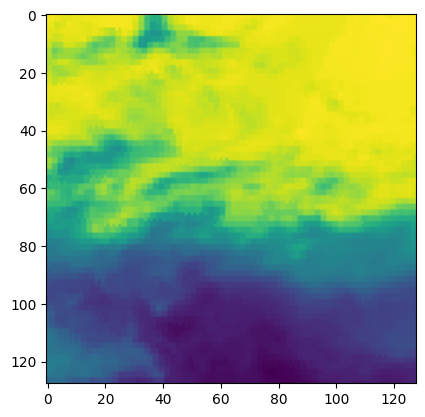

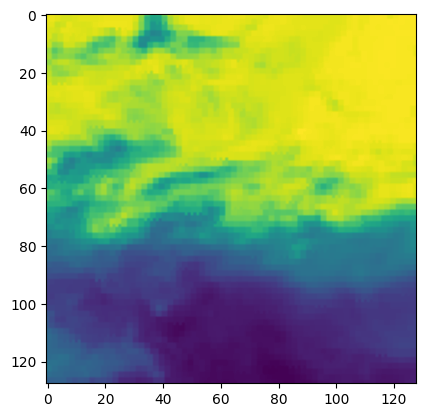

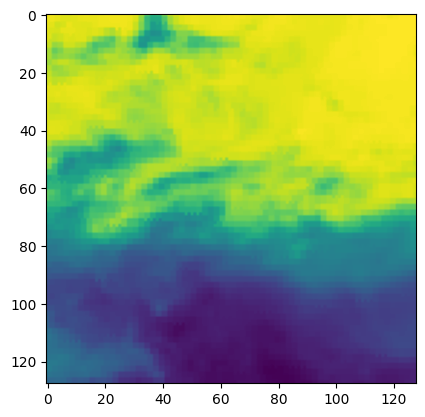

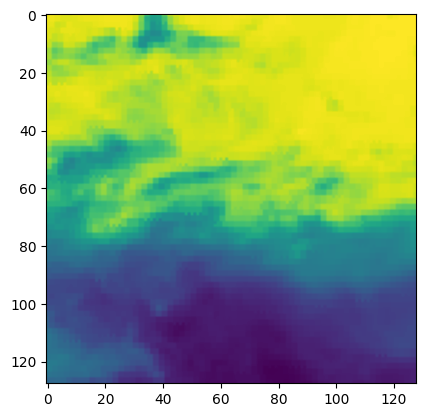

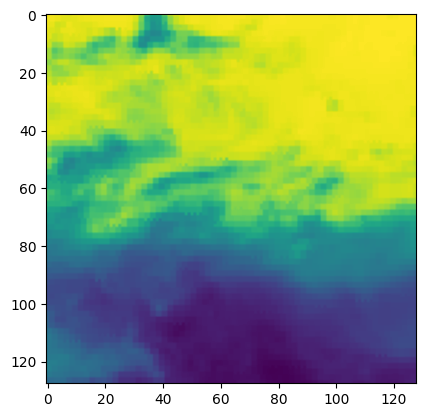

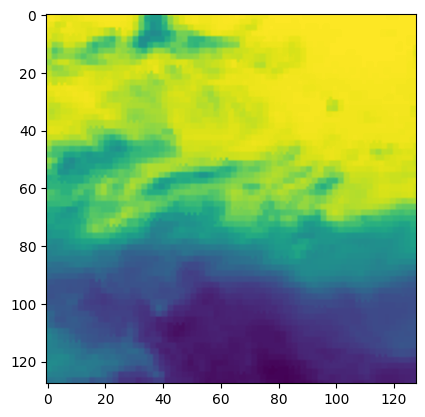

In [5]:
import matplotlib.pyplot as plt
for ele in data['X_train_128'][0]:
    plt.imshow(ele)
    plt.show()

In [6]:
print(data['Y_train_128'][0])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


In [7]:
# from transformers.models.segformer import SegformerConfig, SegformerForSemanticSegmentation, SegformerModel
# config = SegformerConfig(num_channels=16, num_labels=2)
# model = SegformerForSemanticSegmentation(config=config)
# model.to('cuda')

In [8]:
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models import efficientnet_b1
import torch


class MyBackBone(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = efficientnet_b1(weights=None)
        self.model.features[0][0] = torch.nn.Conv2d(
            16, 32, (3, 3), (2, 2), (1, 1), bias=False)
        self.adapter = torch.nn.Conv2d(1280, 2048, kernel_size=1, bias=False)

    def forward(self, inputs: torch.Tensor):
        x = self.model.features(inputs)
        x = self.adapter(x)
        return {"out": x}


model = deeplabv3_resnet50(weights=None, weights_backbone=None, num_classes=2)
backbone = MyBackBone()
model.backbone = backbone
model.to('cuda')
print(model)

DeepLabV3(
  (backbone): MyBackBone(
    (model): EfficientNet(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split


class MyDataset(Dataset):
    def __init__(self, X_train, Y_train):
        super().__init__()
        self.X_train = X_train
        self.Y_train = Y_train

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, index):
        return {'data': torch.from_numpy(self.X_train[index]).float(),
                'label': torch.from_numpy(self.Y_train[index]).long()}

In [10]:
from pytorch_lightning import seed_everything
seed_everything(42, workers=4)
dataset = MyDataset(data['X_train_128'], data['Y_train_128'])
train_size = int(len(dataset) * 0.8)
val_size = int(len(dataset) - train_size)
print(train_size, val_size)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# print(train_dataset[0]['label'])
test_dataset = MyDataset(data['X_test_128'], data['Y_test_128'])

423 106


In [11]:
train_dataloader = DataLoader(
    train_dataset, 36, True, num_workers=4
)
val_dataloader = DataLoader(
    val_dataset, 36, False, num_workers=4
)
test_dataloader = DataLoader(
    test_dataset, 36, False, num_workers=4
)

In [12]:
# for idx, batch in enumerate(train_dataloader):
#     print(model(batch['data'].to('cuda')))
#     if idx == 0:
#         break

In [15]:
from torchmetrics.segmentation import DiceScore
import pytorch_lightning as pl
from torchvision.ops import sigmoid_focal_loss
from torchmetrics.classification import BinaryAccuracy
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import accuracy_score


class DiceLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dice_score = DiceScore(2, input_format='one-hot')

    def forward(self, inputs, targets):
        y_hat = (torch.sigmoid(inputs) > 0.5).int()
        y_true = torch.nn.functional.one_hot(targets, 2).permute((0, 3, 1, 2))
        return 1 - self.dice_score(y_hat, y_true)

# class BinaryFocalLoss(torch.nn.Module):
#     def __init__(self, gamma=2, num_classes=2):
#         self.gamma = gamma
#         self.num_classes = 2

#     def forward(self, inputs, targets):
#         alpha = len(inputs)/len(targets


class WrapperModel(pl.LightningModule):
    def __init__(self, lr=1e-3, sigma=0.1):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.model = model
        self.loss_1 = DiceLoss()
        self.loss_2 = torch.nn.CrossEntropyLoss()
        # self.loss_2 = torch.nn.BCEWithLogitsLoss()
        self.train_preds = []
        self.train_targets = []
        self.val_preds = []
        self.val_targets = []

    def forward(self, inputs):
        return self.model(inputs)

    def training_step(self, batch: torch.Tensor, batch_idx):
        y_hat = self.model(batch['data'])['out']
        y_true = batch['label'].to(batch['data'].device)
        loss = self.loss_1(y_hat, y_true) + self.loss_2(y_hat, y_true)
        self.log("train_loss", loss, prog_bar=True)

        # Sửa ở đây: dùng input_format='index'
        dice_score = DiceScore(2, input_format='index')(
            torch.argmax(y_hat, dim=1), y_true)
        self.log("train_dice_score", dice_score, prog_bar=True)
        image_level_acc = accuracy_score(torch.argmax(y_hat, dim=1).detach().cpu().numpy().flatten(), y_true.detach().cpu().numpy().flatten())
        self.log("train_image_level_acc", image_level_acc, prog_bar=True)
        self.log("learning rate", self.lr)
        return loss

    def validation_step(self, batch: torch.Tensor, batch_idx):
        y_hat = self.model(batch['data'])['out']
        y_true = batch['label'].to(batch['data'].device)
        loss = self.loss_1(y_hat, y_true) + self.loss_2(y_hat, y_true)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True, on_step=False)

        # Sửa ở đây: dùng input_format='index'
        dice_score = DiceScore(2, input_format='index')(
            torch.argmax(y_hat, dim=1), y_true)
        self.log("val_dice_score", dice_score,
                 prog_bar=True, on_epoch=True, on_step=False)
        image_level_acc = accuracy_score(torch.argmax(y_hat, dim=1).detach().cpu().numpy().flatten(), y_true.detach().cpu().numpy().flatten())
        self.log("val_image_level_acc", image_level_acc,
                 prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=7),
                'monitor': 'val_loss'
            }
        }


trainer = pl.Trainer(
    callbacks=[
        ModelCheckpoint(dirpath='checkpoints/weather_home_segformer',
                        monitor='val_loss', save_last=True, filename='best'),
        EarlyStopping(monitor='val_loss', patience=10, mode='min')
    ],
    logger=[
        TensorBoardLogger(save_dir="tb_logs", name="weather_home_segformer")
    ],
    # gradient_clip_val=1.0,
    # gradient_clip_algorithm='norm',
    max_time="00:00:15:00"
)
model = WrapperModel()

In [16]:
import warnings
warnings.filterwarnings('ignore')
trainer.fit(model, train_dataloader, val_dataloader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [17]:
trainer.validate(model, test_dataloader)

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      val_dice_score       │    0.7470918297767639     │
│    val_image_level_acc    │    0.7470918297767639     │
│         val_loss          │    0.7892491817474365     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.7892491817474365,
  'val_dice_score': 0.7470918297767639,
  'val_image_level_acc': 0.7470918297767639}]